# Closed Toda

In [1]:
import sys
sys.path.append("../")
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt

In [2]:
from hamiltonians import closed_toda
from utils import visualize_chain_bijector_1d, extract_q_p, join_q_p, is_symplectic, run_eagerly, BaseDistributionNormal
from utils import hamiltonian_traj

In [3]:
# tf.enable_eager_execution()
sess = tf.InteractiveSession()
tf.set_random_seed(0)

## Look at a trajectory

In [18]:
N = 3
dims = {'d': 1, 'num_particles': N}
init_state = tf.random_normal([2*N])
# Need to remove centre of mass motion
qs, ps = init_state[::2], init_state[1::2]
ps = ps - tf.reduce_mean(ps)
init_state = tf.stack([qs, ps], axis=1)
init_state = tf.reshape(init_state, shape=[-1])

traj = hamiltonian_traj(lambda x: closed_toda(x), init_state, dims, time=50, steps=1000)

traj_np = sess.run(traj)

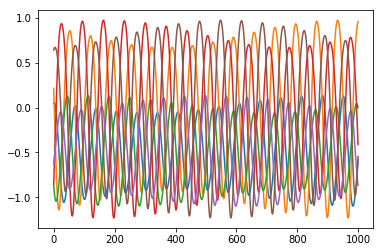

In [19]:
plt.plot(traj_np)

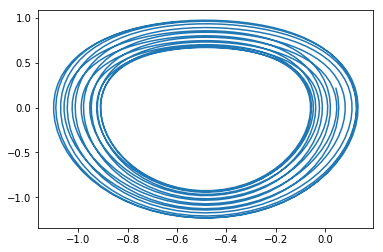

In [21]:
q_traj, p_traj = extract_q_p(traj_np)
plt.plot(q_traj[:,0], p_traj[:,0])

Note (Roberto) : I got many times "underflow in dt" error when using odeint (problem with adaptive dt that gets too small)

## Go to normal modes

In [10]:
qs, ps = tf.spectral.rfft(fpu_traj[:,::2]), tf.spectral.rfft(fpu_traj[:,1::2])

In [11]:
q_np, p_np = sess.run([qs, ps])

For `rfft` output is of size $n/2 + 1$, with the first entry being the zero mode

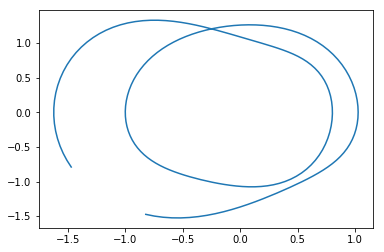

In [12]:
plt.plot(np.real(q_np[:,1]), np.real(p_np[:,1]))

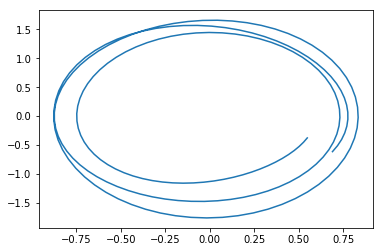

In [13]:
plt.plot(np.imag(q_np[:,2]), np.imag(p_np[:,2]))

We see that for weak nonlinearity we can still see the oscillatory behaviour of normal modes

## Learn a transformation

In [14]:
# Suppress the warning till they fix this:
# lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: 
# DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
import warnings
warnings.filterwarnings("ignore")

In [15]:
DTYPE=tf.float32
NP_DTYPE=np.float32
settings = {
    'hamiltonian': (lambda x: fpu_hamiltonian(x, alpha=α)),
    'd': 1,               # space dimension
    'num_particles': 2*(N//2),   # Note that we are going to ignore the zero mode.
    'batch_size': 1024,    # Mini batch size 
    'stack_size': 4}        # How many sets of NICE / SymplecticExchange / LinearSymplecticTwoByTwo

In [16]:
bijectors = []
for _ in range(settings['stack_size']):
    bijectors.extend([SymplecticExchange(),
                      SymplecticAdditiveCoupling(shift_model=IrrotationalMLP(activation=tf.nn.tanh, width=32)),
                      LinearSymplecticTwoByTwo()])
model = Chain(bijectors)

## Set up the loss

Need to map from the normal mode amplitudes to the real space coordinates

In [17]:
def modes_to_coords(amps):
    """map the mode amplitudes to coordinates. amps.shape = [batch_size, 1, 2*(N//2), 2] with:
    amps[b,0,:,0] = [q_r1, q_i1, ...], amps[b,0,:,1] = [p_r1, p_i1, ...] for q_r and q_i the real and 
    imaginary amplitudes.
    output: [q_1, ..., q_N], [p_1, .... p_N]
    
    A zero mode is added with zero amplitude
    """
    #amp = tf.to_complex64(amps)
    q_modes, p_modes = extract_q_p(amps) # q,p_modes shape = [b,1,n,1] each
    complex_q_modes = tf.complex(q_modes[:,:,::2,0], q_modes[:,:,1::2,0])
    complex_p_modes = tf.complex(p_modes[:,:,::2,0], p_modes[:,:,1::2,0])
    zero_mode = tf.zeros_like(complex_q_modes[:,:,:1], dtype=tf.complex64)
    complex_q_modes = tf.concat([zero_mode, complex_q_modes], axis=-1)
    complex_p_modes = tf.concat([zero_mode, complex_p_modes], axis=-1)
    q = tf.expand_dims(tf.spectral.irfft(complex_q_modes), axis=-1)
    p = tf.expand_dims(tf.spectral.irfft(complex_p_modes), axis=-1)
    return join_q_p(q, p)

In [18]:
with tf.name_scope("loss"):
    # Sample the modes
    base_dist = BaseDistributionNormal(settings)
    z_samples = base_dist.sample(settings['batch_size'])
    coords = modes_to_coords(z_samples)
    Hprime = settings['hamiltonian'](model(coords))
    Hprime_grads = tf.gradients(Hprime, z_samples)[0]
    q, p = extract_q_p(z_samples)
    q_grads, p_grads = extract_q_p(Hprime_grads)
    loss = tf.reduce_mean(tf.square(q * p_grads - p * q_grads))

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


## Train

In [19]:
step = tf.get_variable("global_step", [], tf.int64, tf.zeros_initializer(), trainable=False)
train_op = tf.train.AdamOptimizer(1e-3).minimize(loss, global_step=step)

In [20]:
tf.summary.scalar("loss_function", tf.reshape(loss, []))

<tf.Tensor 'loss_function:0' shape=() dtype=string>

In [21]:
tf.contrib.training.train(train_op, logdir="../fpu-logging", save_checkpoint_secs=60)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ../fpu-logging/model.ckpt.
INFO:tensorflow:global_step/sec: 40.131
INFO:tensorflow:global_step/sec: 71.9583
INFO:tensorflow:global_step/sec: 67.8032
INFO:tensorflow:global_step/sec: 70.7618
INFO:tensorflow:global_step/sec: 64.5086
INFO:tensorflow:global_step/sec: 76.2169
INFO:tensorflow:global_step/sec: 66.3311
INFO:tensorflow:global_step/sec: 70.0588
INFO:tensorflow:global_step/sec: 68.5648
INFO:tensorflow:global_step/sec: 69.0786
INFO:tensorflow:global_step/sec: 64.8304
INFO:tensorflow:global_step/sec: 63.2486
INFO:tensorflow:global_step/sec: 69.5163
INFO:tensorflow:global_step/sec: 59.538
INFO:tensorflow:global_step/sec: 60.7352
INFO:tensorflow:global_step/sec: 61.8306
INFO:tensorflow:global_step/sec: 61.4037
INFO:tensorflow:global_step/sec: 65.0411
INFO:tensorflow:global_step

INFO:tensorflow:global_step/sec: 68.1156
INFO:tensorflow:global_step/sec: 60.8071
INFO:tensorflow:global_step/sec: 65.5537
INFO:tensorflow:global_step/sec: 69.0935
INFO:tensorflow:global_step/sec: 64.6131
INFO:tensorflow:global_step/sec: 60.8872
INFO:tensorflow:global_step/sec: 70.2187
INFO:tensorflow:global_step/sec: 70.7059
INFO:tensorflow:Saving checkpoints for 19645 into ../fpu-logging/model.ckpt.
INFO:tensorflow:global_step/sec: 42.155
INFO:tensorflow:global_step/sec: 67.9054
INFO:tensorflow:global_step/sec: 65.6431
INFO:tensorflow:global_step/sec: 72.6198
INFO:tensorflow:global_step/sec: 65.1592
INFO:tensorflow:global_step/sec: 62.2249
INFO:tensorflow:global_step/sec: 65.1434
INFO:tensorflow:global_step/sec: 68.4795
INFO:tensorflow:global_step/sec: 63.4873
INFO:tensorflow:global_step/sec: 72.2419
INFO:tensorflow:global_step/sec: 70.6841
INFO:tensorflow:global_step/sec: 68.7098
INFO:tensorflow:global_step/sec: 69.3307
INFO:tensorflow:global_step/sec: 65.4616
INFO:tensorflow:global

KeyboardInterrupt: 

## Look at the learned representation

In [22]:
traindir = "../fpu-logging"
saver = tf.train.Saver()

ckpt_state = tf.train.get_checkpoint_state(traindir)
saver.restore(sess, ckpt_state.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from ../fpu-logging/model.ckpt-27467


In [23]:
def coords_to_modes(coords):
    qs, ps = extract_q_p(coords)
    qs = tf.squeeze(qs) # Eliminate the axis 1 and -1
    ps = tf.squeeze(ps)
    
    q_modes, p_modes = tf.spectral.rfft(qs), tf.spectral.rfft(ps)
        
    q_modes = q_modes[:,1:] # Remove the zero mode
    p_modes = p_modes[:,1:]
    q_modes_r, q_modes_i = tf.real(q_modes), tf.imag(q_modes)
    p_modes_r, p_modes_i = tf.real(p_modes), tf.imag(p_modes)

    n = q_modes_r.shape[1]
    q_modes = tf.reshape(tf.concat([q_modes_r, q_modes_i], 1), [-1, 1, 2*n, 1])
    p_modes = tf.reshape(tf.concat([p_modes_r, p_modes_i], 1), [-1, 1, 2*n, 1])    
    
    amps = join_q_p(q_modes, p_modes)
    return amps

In [24]:
# note: reshape([1,2,3,4],(2,2)) -> [[1,2],[3,4]] so that 0th col is even entries and 1st is odd entries
coords = tf.reshape(fpu_traj, (-1,settings['d'],settings['num_particles'],2)) 
traj_amps = coords_to_modes(coords)
np_traj_amps = sess.run(traj_amps)

In [25]:
np_trans_amps = sess.run(model.inverse(np_traj_amps))

In [26]:
np_traj_amps = np.transpose(np.reshape(np_traj_amps, (-1,4,2)), (1,2,0))
np_trans_amps = np.transpose(np.reshape(np_trans_amps, (-1,4,2)), (1,2,0))

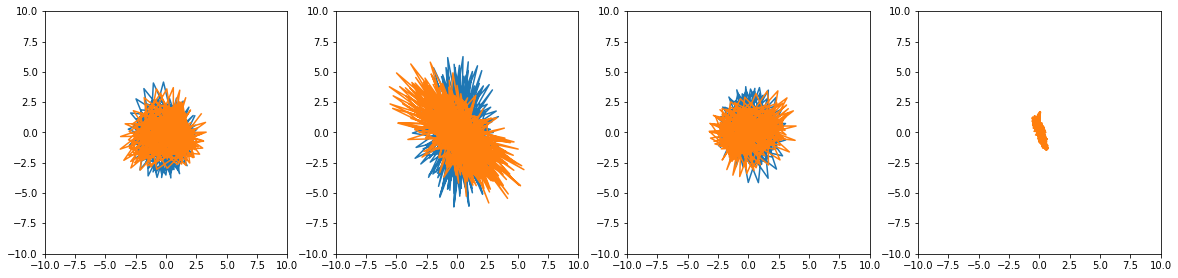

In [27]:
plt.figure(figsize=(20,20))

for idx, mode in enumerate(np_traj_amps):
    plt.subplot(2, 4, idx+1)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    
    plt.plot(mode[0], mode[1])
    plt.plot(np_trans_amps[idx,0], np_trans_amps[idx,1])
    plt.gca().set_aspect('equal', adjustable='box')